In [1]:
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch


from tqdm.notebook import trange, tqdm
from omegaconf import OmegaConf, DictConfig

# Set precision to 3 decimal places
np.set_printoptions(precision=3, suppress=True)

import pickle

from discrete_maze.maze import Maze
from discrete_maze.search_algorithm import GreedyAlgorithm, SearchAlgorithm,  LearnedAStar
from discrete_maze.maze_dataset import MazeDataset
from discrete_maze.resnet import ResNet

In [2]:
# Define the configuration using OmegaConf
cfg = OmegaConf.create({
    "maze": {
        "width": {"min": 4, "max": 50},
        "height": {"min": 4, "max": 50},
        "cell_occupancy_prob": {"min": 0, "max": 0.3},
        "max_steps": "ShortestPath", # Use this to set the max steps to the shortest path between source and target * 2
        # "max_steps": "L1SourceTarget", # Use this to set the max steps to the L1 distance between source and target * 2
        # To set paramters to constant values, use a float
        # "width": 4,
        # "height": 4,
        # "cell_occupancy_prob": 0,
        # "max_steps": 5, 
    },
    "model": {
        "num_resBlocks": 4,
        "num_filters": 64,
        "history_length": 8, # Number of current and previous states to consider, 1 for current state only
    },
    "search": {
        # MCTS configuration
        "num_simulations": 300,
        "c_puct": 2,
    },
})

In [3]:
import pandas as pd

def summarize_results(results, name):
    df = pd.DataFrame(results, columns=['termination_case', 'value'])
    percentages = df['termination_case'].value_counts(normalize=True) * 100

    # Compute average optimal path ratio for successful runs
    average_optimal_path_ratio = df['value'].mean()

    print(f"Results for {name}:")
    print(f"% Target Reached: {percentages.get(SearchAlgorithm.TerminationCase.TARGET_REACHED, 0):.2f}%")
    print(f"% Timed Out: {percentages.get(SearchAlgorithm.TerminationCase.TIMEOUT, 0):.2f}%")
    print(f"% Collided: {percentages.get(SearchAlgorithm.TerminationCase.COLLISION, 0):.2f}%")
    print(f"% Failed: {percentages.get(SearchAlgorithm.TerminationCase.FAILED, 0):.2f}%")
    print(f"Average path_length/optimal_path_length: {average_optimal_path_ratio:.4f}\n")

  0%|          | 0/1 [00:00<?, ?it/s]

A* expanded 118 nodes


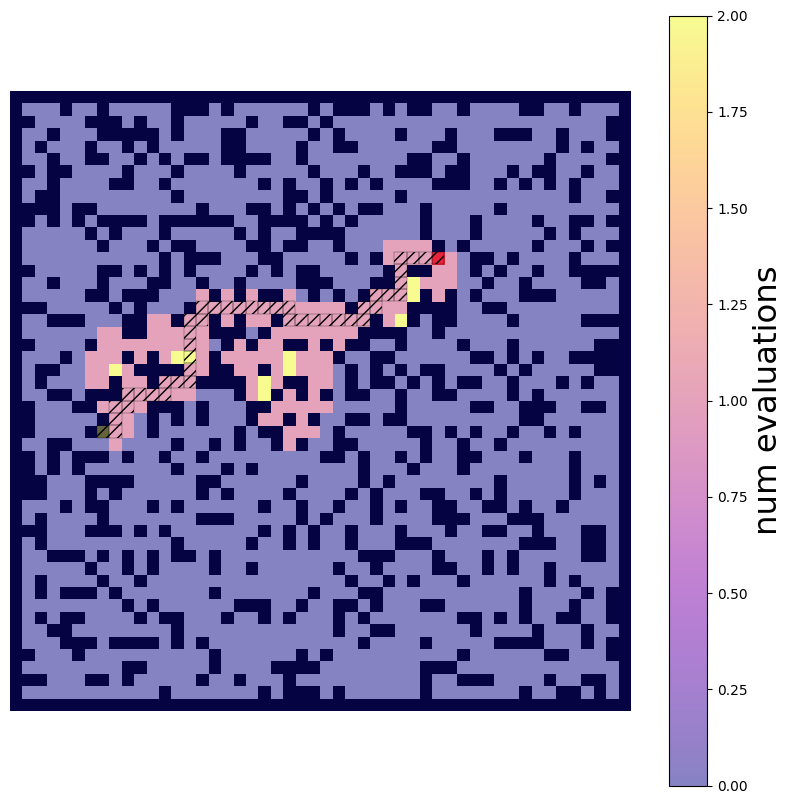

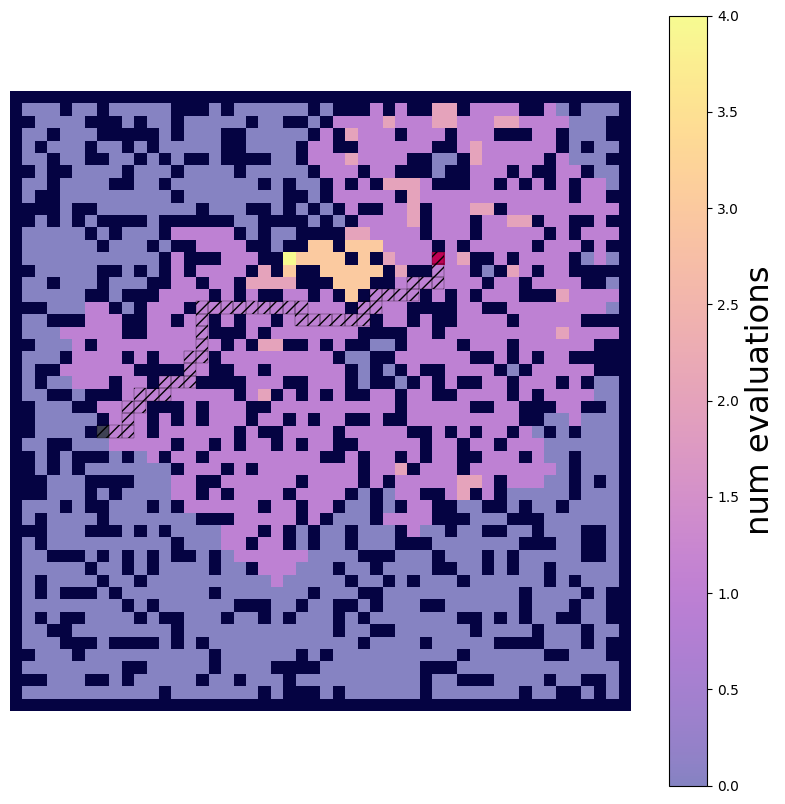

LearnedAStar expanded 764 nodes


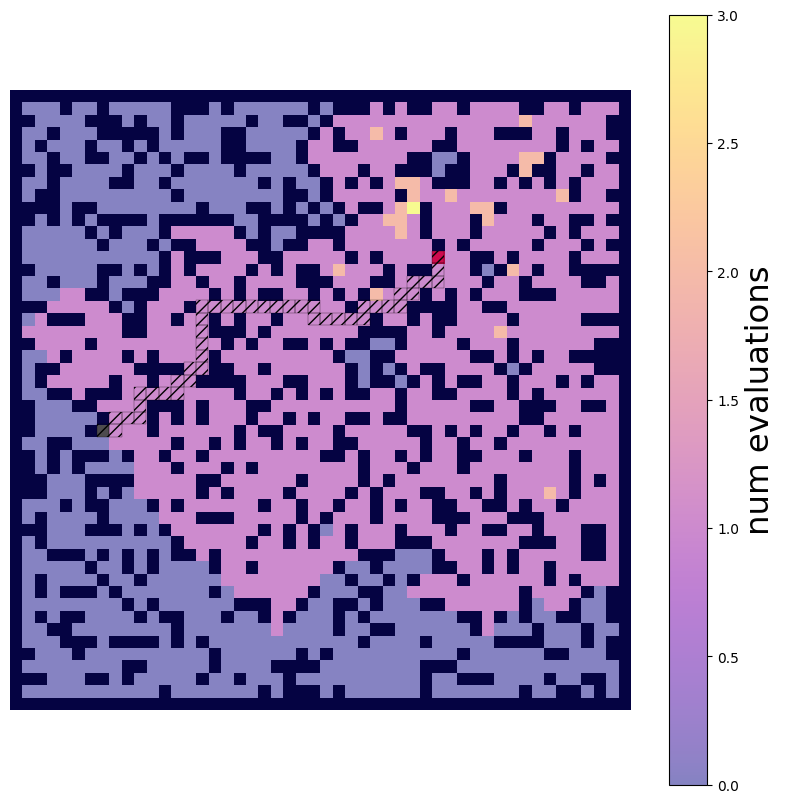

LearnedAStar expanded 970 nodes
Results for Behavior Cloning 500k:
% Target Reached: 100.00%
% Timed Out: 0.00%
% Collided: 0.00%
% Failed: 0.00%
Average path_length/optimal_path_length: 1.0000

Results for Behavior Cloning 50k:
% Target Reached: 100.00%
% Timed Out: 0.00%
% Collided: 0.00%
% Failed: 0.00%
Average path_length/optimal_path_length: 1.0000



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_to_test = {
    "Behavior Cloning 500k": f"../checkpoints/maze_4to50_0to0p3_500000_bc_model_{14}.pt",
    "Behavior Cloning 50k": f"../checkpoints/maze_4to50_0to0p3_50000_bc_model_{10}.pt",
    # "Expert Iteration n_sim 50": f"../checkpoints/maze_4to100_hist8_model_{99}.pt",
    # "Expert Iteration n_sim 300": f"../checkpoints/maze_4to100_hist8_numsim300_model_{99}.pt",
}
models = {}
for name, path in models_to_test.items():
    model = ResNet(cfg.model, device)
    model.load_state_dict(torch.load(path, weights_only=True))
    models[name] = model


n_games = 1
results = {model_name: [] for model_name in models.keys()}
algs = {model_name: LearnedAStar(search_cfg=None, model=model) for model_name, model in models.items()}


for _ in trange(n_games):
    maze_params = Maze.generate_maze_params(1, maze_cfg=cfg.maze)
    # maze = Maze(*maze_params[0])
    maze = Maze(50,50,0.3,"ShortestPath")
    for model_name, alg in algs.items():
        results[model_name].extend([alg.play_game(maze, verbose=True, visualize=True)])

for model_name, model_results in results.items():
    summarize_results(model_results, model_name)